In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import qiskit
from qiskit.test.mock import FakeAthens
from qiskit.ignis.experiments.calibration import mock

fake_backend = FakeAthens()

## Model

Basis gate can be further lowered into instructions. For example:

$$
U2(\phi, \lambda) = RZ(\phi).RY(\frac{\pi}{2}).RZ(\lambda)
$$

In context of calibration, we need to prepare database with these atomic instructions. In what follows, this database is called _calibration table_.
With the generator model, we don't need to prepare entry for composite gate. Any composite instruction can be constructed within the generator $G$ if the generator knows the name of all underlying atomic instructions (by acquiring instruction data to the table $T$). For example:

$$
G(\{ U_{90+, 0}, U_{90+, 1}, U_{90-, 0}, U_{90-, 1}, X_{0} \}) \longrightarrow {\rm CR_{10}}, \hspace{2mm} {\rm where~.e.g.} \hspace{5mm} T({\rm u90p, 0}) = U_{90+,0}
$$

So we need to feed calibration table into a generator, and the generator internally assembles required pulse sequence. If an entry in the table is parametrized, generated sequence will be also paramerterized.

Finally, we can construct basis gates with the complete calibration table. This requires system information such as relationship of channel frames.

$$
{\rm calibration~table~} T \longrightarrow \{\rm basis~gate\}
$$

## 1. Loading calibration table

Load calibration table from server. This is just a mock:

In [6]:
cal_db = mock.FakeDatabase(backend_name=fake_backend.name(), num_qubits=fake_backend.configuration().n_qubits)

In [7]:
table = cal_db.load_calibrations()
table.get_properties('x90p', qubits=[0])

{'duration': 160, 'amp': 0, 'sigma': 40, 'beta': 0}

Once this table is provided, we can write calibration circuit with query like access to underlying gates:

---
```python
def ramsey_xy(
        name: str,
        table: cal_table.CalibrationDataTable,
        target_qubits: List[int],
        meas_basis: Optional[str] = 'z') -> types.Program:
    """Generate Ramsey circuit."""
    n_qubits = table.num_qubits

    with Calib(name=name, n_qubits=n_qubits, meas_basis=meas_basis) as circ_x:
        circ_x.append(table.get_gate(
            instruction=types.SingleQubitAtomicPulses.X90P.value,
            qubits=target_qubits
        ), [0])
        circ_x.delay(circuit.Parameter('delay'), unit='ns', qarg=[0])
        circ_x.append(table.get_gate(
            instruction=types.SingleQubitAtomicPulses.X90P.value,
            qubits=target_qubits
        ), [0])

    with Calib(name=name, n_qubits=n_qubits, meas_basis=meas_basis) as circ_y:
        circ_y.append(table.get_gate(
            instruction=types.SingleQubitAtomicPulses.X90P.value,
            qubits=target_qubits
        ), [0])
        circ_y.delay(circuit.Parameter('delay'), unit='ns', qarg=[0])
        circ_y.append(table.get_gate(
            instruction=types.SingleQubitAtomicPulses.Y90P.value,
            qubits=target_qubits
        ), [0])

        meta_x = {
            'generator': 'ramsey',
            'meas_basis': meas_basis,
            'quad': 'x'
        }
        meta_y = {
            'generator': 'ramsey',
            'meas_basis': meas_basis,
            'quad': 'y'
        }

    return [circ_x, circ_y], [meta_x, meta_y]
```
---

We can parametrize arbitrary parameter. This retunrs a handler of the parameter. Parameter name is generated based on the corresponding generator argument with the namespace generated by the pulse name and channel.

In [8]:
parameter = table.parametrize('x90p', qubits=[0], param_name='amp')

In [9]:
parameter

Parameter(x90p.d0.amp)

Table can return gate as well. This object can be attached to quantum circuit for calibration.

In [10]:
qc = qiskit.QuantumCircuit(1)
qc.append(table.get_gate('x90p', qubits=[0]), [0])
qc.draw()

┌───────────────────┐
q_0: ┤ x90p(x90p.d0.amp) ├
     └───────────────────┘

In [11]:
qc.parameters

{Parameter(x90p.d0.amp)}

We have these atomic instructions for single qubit gates.
```python
class SingleQubitAtomicPulses(Enum):
    """Name of single qubit gates."""
    X90P = 'x90p'
    X90M = 'x90m'
    Y90P = 'y90p'
    Y90M = 'y90m'
    XP = 'xp'
    XM = 'xm'
    YP = 'yp'
    YM = 'ym'
    STIM = 'stimulus'
```

## 2. Calibration

In [12]:
from qiskit.ignis.experiments.calibration.cal_library import RoughAmplitudeCalibration

import numpy as np

In [30]:
%%time
experiment = RoughAmplitudeCalibration(
    table=table,
    qubit=3,
    amp_vals=np.linspace(-0.5, 0.5, 31)
)

CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 65.8 ms


In [31]:
cal_circuits = experiment.generator.circuits()

In [32]:
cal_circuits[0].draw()

┌──────────────────────────────┐ ░ ┌─┐
q_0: ┤ stimulus(-0.500000000000000) ├─░─┤M├
     └──────────────────────────────┘ ░ └╥┘
c: 1/════════════════════════════════════╩═
                                         0

In [33]:
cal_circuits[1].draw()

┌──────────────────────────────┐ ░ ┌─┐
q_0: ┤ stimulus(-0.466666666666667) ├─░─┤M├
     └──────────────────────────────┘ ░ └╥┘
c: 1/════════════════════════════════════╩═
                                         0

In [54]:
cal_circuits[-1].draw()

┌─────────────────────────────┐ ░ ┌─┐
q_0: ┤ stimulus(0.500000000000000) ├─░─┤M├
     └─────────────────────────────┘ ░ └╥┘
c: 1/═══════════════════════════════════╩═
                                        0

In [35]:
cal_metadata = experiment.generator.metadata()

In [36]:
cal_metadata[0]

{'generator': 'rabi',
 'meas_basis': 'z',
 'stimulus.d3.amp': -0.5,
 'name': 'rough_amplitude',
 'qubits': [3]}

In [37]:
cal_metadata[1]

{'generator': 'rabi',
 'meas_basis': 'z',
 'stimulus.d3.amp': -0.4666666666666667,
 'name': 'rough_amplitude',
 'qubits': [3]}

In [53]:
cal_metadata[-1]

{'generator': 'rabi',
 'meas_basis': 'z',
 'stimulus.d3.amp': 0.5,
 'name': 'rough_amplitude',
 'qubits': [3],
 'exp_id': 'c8a58228-d1e0-41ef-a59c-2dd990a79566'}

Check embedded calibration.

In [39]:
cal_circuits[0].calibrations

{'stimulus': {((3,),
   (-0.5,)): Schedule((0, ShiftPhase(0, DriveChannel(3))), (0, ShiftFrequency(0.0, DriveChannel(3))), (0, Play(Drag(duration=160, amp=(-0.5+0j), sigma=40, beta=0), DriveChannel(3), name='stimulus')), (160, ShiftPhase(0, DriveChannel(3))), (160, ShiftFrequency(0.0, DriveChannel(3))), name="stimulus")}}

In [40]:
cal_circuits[1].calibrations

{'stimulus': {((3,),
   (-0.4666666666666667,)): Schedule((0, ShiftPhase(0, DriveChannel(3))), (0, ShiftFrequency(0.0, DriveChannel(3))), (0, Play(Drag(duration=160, amp=(-0.4666666666666667+0j), sigma=40, beta=0), DriveChannel(3), name='stimulus')), (160, ShiftPhase(0, DriveChannel(3))), (160, ShiftFrequency(0.0, DriveChannel(3))), name="stimulus")}}

In [52]:
cal_circuits[-1].calibrations

{'stimulus': {((3,),
   (0.5,)): Schedule((0, ShiftPhase(0, DriveChannel(3))), (0, ShiftFrequency(0.0, DriveChannel(3))), (0, Play(Drag(duration=160, amp=(0.5+0j), sigma=40, beta=0), DriveChannel(3), name='stimulus')), (160, ShiftPhase(0, DriveChannel(3))), (160, ShiftFrequency(0.0, DriveChannel(3))), name="stimulus")}}

Check program to submit.

In [42]:
compiled = experiment.execute(backend=fake_backend)

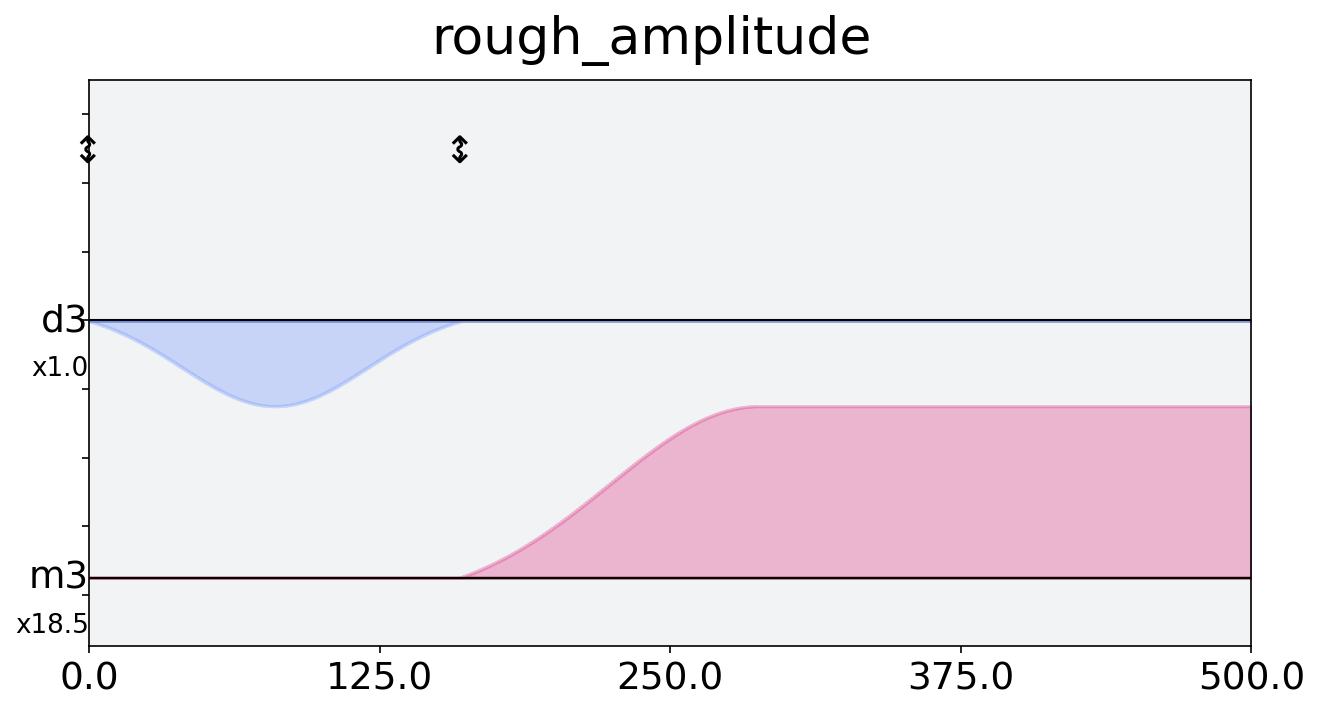

In [48]:
compiled[0][0].draw(plot_range=(0, 500), channel_scales={qiskit.pulse.DriveChannel(3): 1}, channels=[qiskit.pulse.DriveChannel(3), qiskit.pulse.MeasureChannel(3)], style=qiskit.visualization.SchedStyle(figsize=(10, 5)))

In [57]:
compiled[1][0]

{'generator': 'rabi',
 'meas_basis': 'z',
 'stimulus.d3.amp': -0.5,
 'name': 'rough_amplitude',
 'qubits': [3],
 'exp_id': 'c8a58228-d1e0-41ef-a59c-2dd990a79566'}

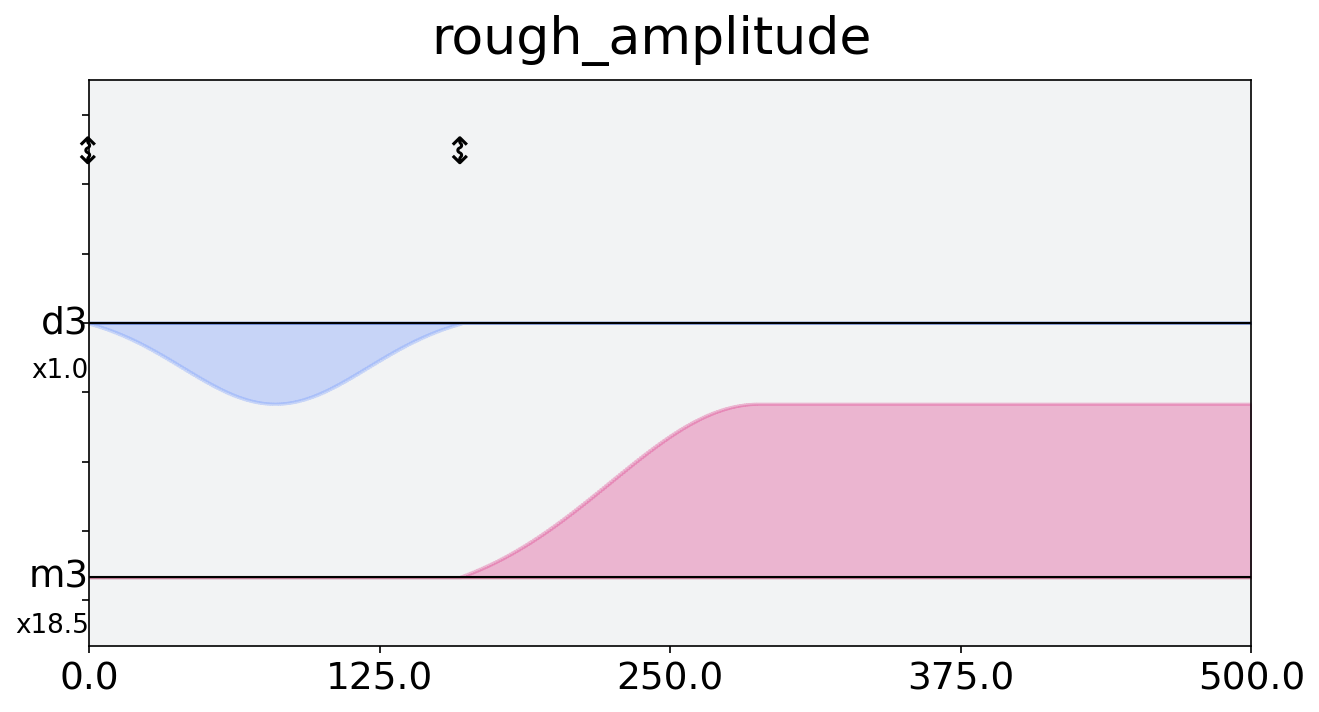

In [49]:
compiled[0][1].draw(plot_range=(0, 500), channel_scales={qiskit.pulse.DriveChannel(3): 1}, channels=[qiskit.pulse.DriveChannel(3), qiskit.pulse.MeasureChannel(3)], style=qiskit.visualization.SchedStyle(figsize=(10, 5)))

In [56]:
compiled[1][1]

{'generator': 'rabi',
 'meas_basis': 'z',
 'stimulus.d3.amp': -0.4666666666666667,
 'name': 'rough_amplitude',
 'qubits': [3],
 'exp_id': 'c8a58228-d1e0-41ef-a59c-2dd990a79566'}

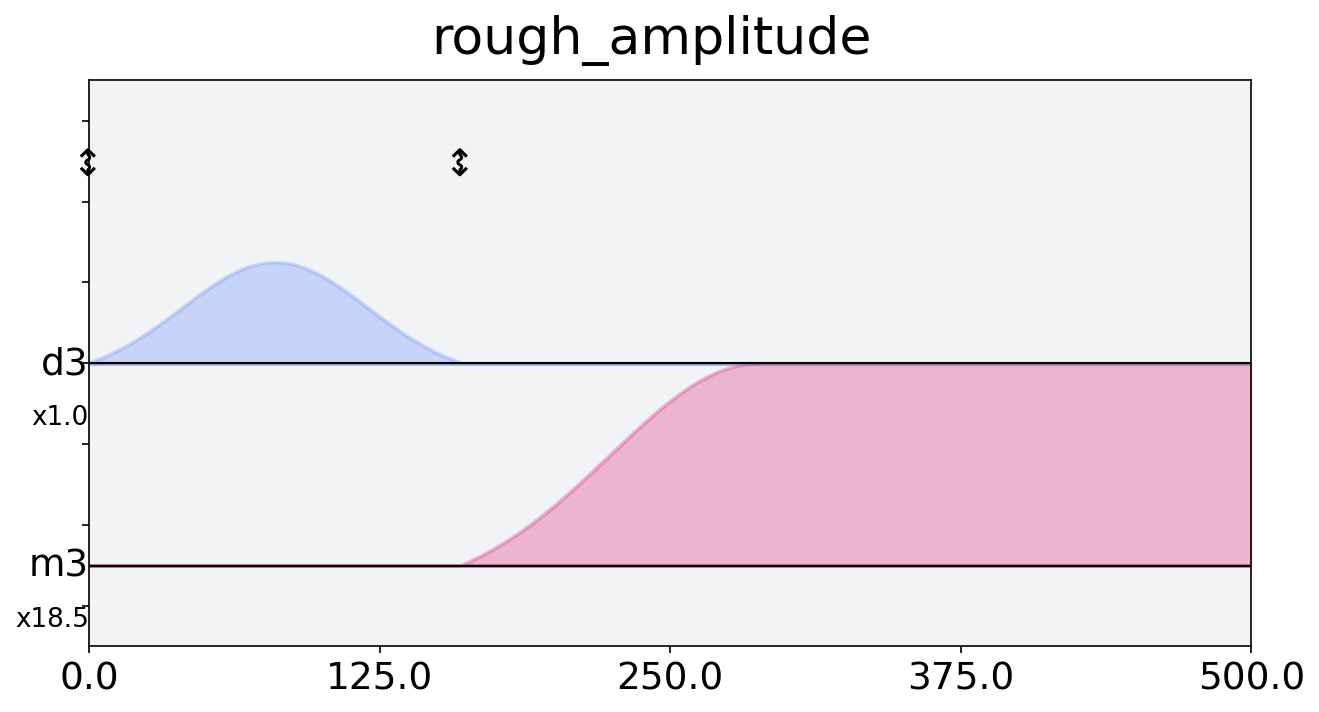

In [51]:
compiled[0][-1].draw(plot_range=(0, 500), channel_scales={qiskit.pulse.DriveChannel(3): 1}, channels=[qiskit.pulse.DriveChannel(3), qiskit.pulse.MeasureChannel(3)], style=qiskit.visualization.SchedStyle(figsize=(10, 5)))

In [55]:
compiled[1][-1]

{'generator': 'rabi',
 'meas_basis': 'z',
 'stimulus.d3.amp': 0.5,
 'name': 'rough_amplitude',
 'qubits': [3],
 'exp_id': 'c8a58228-d1e0-41ef-a59c-2dd990a79566'}

The actual experiment class looks like::

---
```python
class RoughAmplitudeCalibration(cal_base.BaseCalibrationExperiment):

    # pylint: disable=arguments-differ
    def __init__(self,
                 table: cal_table.CalibrationDataTable,
                 qubit: int,
                 amp_vals: np.ndarray,
                 analysis: Optional[Analysis] = None,
                 job: Optional = None):
        entry = types.SingleQubitAtomicPulses.STIM.value

        if not table.has(
            instruction=entry,
            qubits=[qubit]
        ):
            raise CalExpError('Entry {name} does not exist. '
                              'Check your calibration table.'.format(name=entry))

        # parametrize table
        amp = table.parametrize(
            instruction=entry,
            qubits=[qubit],
            param_name='amp'
        )

        # setup generator
        generator = cal_base.BaseCalibrationGenerator(
            cal_name='rough_amplitude',
            target_qubits=[qubit],
            cal_generator=methods.rabi,
            table=table,
            meas_basis='z'
        )
        generator.assign_parameters({amp: amp_vals})

        super().__init__(generator=generator, analysis=analysis, job=job)
```
---

Here at the constructor calibration table is parametrized and feed into generator. Parameter handler is used when assigining scanning parameters.